In [4]:
import sys
import os
import system_config as sc

system_configuration = sc.get_system_config()
sys.path.insert(0, system_configuration['code_tensorlfow'])

import input_data
import models

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

## all the arguments of tensorflow's tutorial.
## files management.
data_url      = 0
data_dir      = system_configuration['data_tensorflow']
summaries_dir = os.path.join(system_configuration['train_log_debug'],'retrain_log'  )
# wanted_words  = 'yes,no,up,down,left,right,on,off,stop,go,zero,one,two,three,four,five,six,seven,eight,nine,bed,marvin,sheila,wow,bird,cat,dog,happy,house'
wanted_words  = 'yes,no,up,down,left,right,on,off,stop,go'
train_dir     = os.path.join(system_configuration['train_log_debug'], 'speech_commands_train')
start_checkpoint="E:/Juyue/tmp_conv_triplet_10_1/speech_commands_train\\conv_with_triplet_loss.ckpt-1200"
check_nans=False
# help='Whether to check for invalid numbers during processing')

## training management
background_volume = 0.1
background_frequency=0.8
silence_percentage=10.0
unknown_percentage=10.0
testing_percentage=10
validation_percentage=10
time_shift_ms =100.0
how_many_training_steps=['15000,3000']
eval_step_interval=400
# help='How often to evaluate the training results.')
batch_size=100
save_step_interval=100

## model management
model_architecture='conv'
learning_rate=['0.001,0.0001']

## parameter management

## audio processing management.
sample_rate = 16000
clip_duration_ms = 1000
window_size_ms = 30.0
# help='How long each spectrogram timeslice is',)
window_stride_ms = 10.0
# help='How long each spectrogram timeslice is',)
dct_coefficient_count = 13

## our parameter
# clean up the data a little bit
pct_thresh = [5, 99]

mfcc_normalization_flag = False
batch_normalization_flag = False


In [5]:
import input_data
import models
import evaluate_utils

tf.reset_default_graph()
# We want to see all the logging messages for this tutorial.
tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

# Begin by making sure we have the training data we need. If you already have
# training data of your own, use `--data_url= ` on the command line to avoid
# downloading.
model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(wanted_words.split(','))),
    sample_rate, clip_duration_ms, window_size_ms,
    window_stride_ms, dct_coefficient_count, mfcc_normalization_flag, batch_normalization_flag)
audio_processor = input_data.AudioProcessor(
    data_url, data_dir, silence_percentage,
    unknown_percentage,
    wanted_words.split(','), validation_percentage,
    testing_percentage, model_settings)

fingerprint_size = model_settings['fingerprint_size']
label_count = model_settings['label_count']
# time_shift_samples = int((FLAGS.time_shift_ms * FLAGS.sample_rate) / 1000)

fingerprint_anchor = tf.placeholder(
  tf.float32, [None, fingerprint_size], name='fingerprint_anchor')
fingerprint_positive = tf.placeholder(
  tf.float32, [None, fingerprint_size], name='fingerprint_positive')
fingerprint_negative = tf.placeholder(
  tf.float32, [None, fingerprint_size], name='fingerprint_negative')

logits, loss_triplet, dropout_prob, is_training_flag, trainable_encoding_var_list = models.create_verification_model([fingerprint_anchor , fingerprint_positive, fingerprint_negative], model_settings)



# Define loss and optimizer
ground_truth_input = tf.placeholder(
    tf.int64, [None], name='groundtruth_input')

# Optionally we can add runtime checks to spot when NaNs or other symptoms of
# numerical errors start occurring during training.
predicted_indices = tf.argmax(logits, 1)
correct_prediction = tf.equal(predicted_indices, ground_truth_input)
confusion_matrix = tf.confusion_matrix(
    ground_truth_input, predicted_indices, num_classes=label_count)
evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

global_step = tf.train.get_or_create_global_step()

saver = tf.train.Saver(tf.global_variables())

## start running.
tf.global_variables_initializer().run()

start_step = 1

if start_checkpoint:
    models.load_variables_from_checkpoint(sess, start_checkpoint)
    start_step = global_step.eval(session=sess)

INFO:tensorflow:Restoring parameters from E:/Juyue/tmp_conv_triplet_10_1/speech_commands_train\conv_with_triplet_loss.ckpt-1200


In [6]:
word_list = audio_processor.words_list[2:]

In [7]:
word_list

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

In [8]:
curr = tf.get_default_graph()

In [9]:
encoding_anchor = curr.get_tensor_by_name('encodinganchor/Add:0')
how_many = 10
encoding_vector = [None for ii in range(len(word_list))]
for ii in range(len(word_list)):
    which_word = word_list[ii]
    fingerprints_word, _, _, = audio_processor.get_data_all_data_one_word(which_word, how_many, 0, model_settings, sess)
    feed_dict={
    fingerprint_anchor: fingerprints_word,
    dropout_prob: 1,
    is_training_flag: False
    }
    encoding_vector[ii] = sess.run(encoding_anchor,feed_dict)
encoding_vector = np.array(encoding_vector)


In [10]:
encoding_vector.shape
## BETTER THAN BEFORE. FIRST, TEST THAT 28. VALIDATION SET. TONIGHT!
## every one is more or less the same.
## if you use this encoding... it will be a disaster. because the learning rate is too large... 

(10, 10, 64)

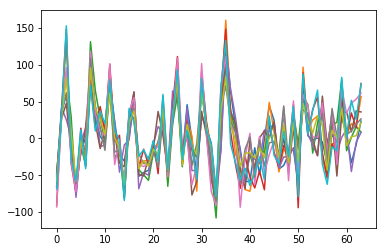

In [11]:
averaged_encoding = np.sum(encoding_vector, axis = 1)
averaged_encoding.shape
plt.plot(np.transpose(averaged_encoding))
plt.show()

In [12]:
eigenvalue = [None for ii in range(len(word_list))]
eigenvector = [None for ii in range(len(word_list))]
for ii in range(len(word_list)):
    covariance_matrix = np.cov(encoding_vector[ii], rowvar=False)
    eigenvalue[ii], eigenvector[ii] = np.linalg.eig(covariance_matrix)
for ii in range(len(word_list)):

    fig = plt.figure(figsize=(15, 3))
    for ee in range(6):
        ax = plt.subplot(1, 7, ee + 1)
        ax.plot(eigenvector[ii][:, ee])
    ax = plt.subplot(1, 7, 7)
    ax.plot(eigenvalue[ii])

C:\ProgramData\Anaconda3\envs\kaggle_speechrec\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


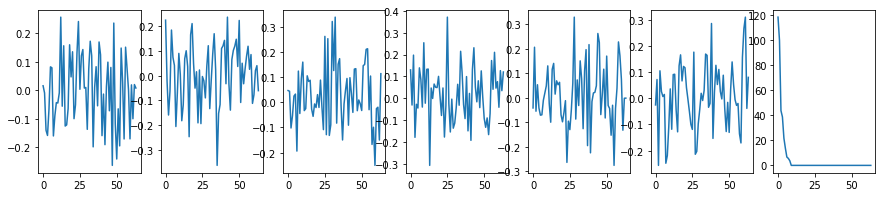

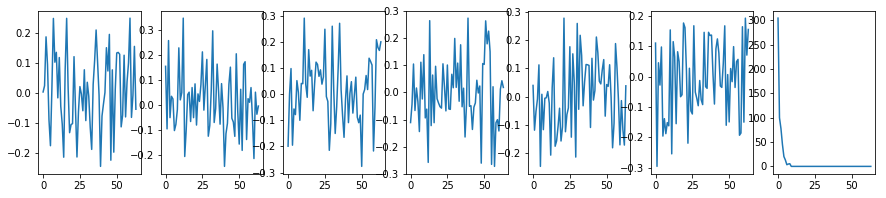

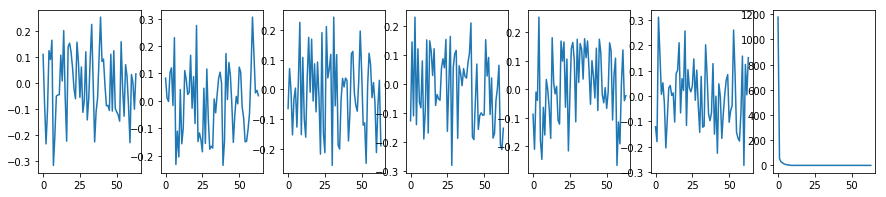

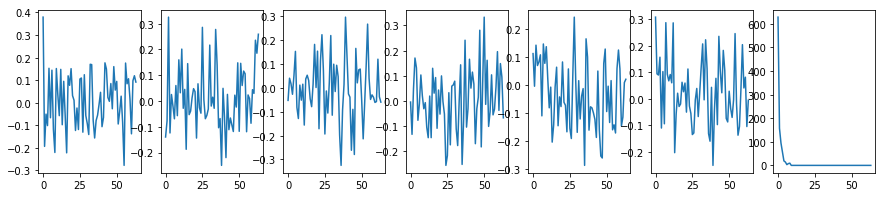

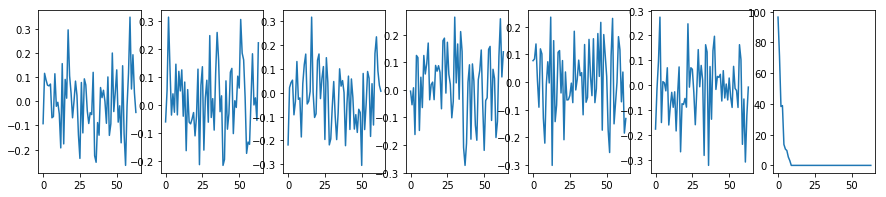

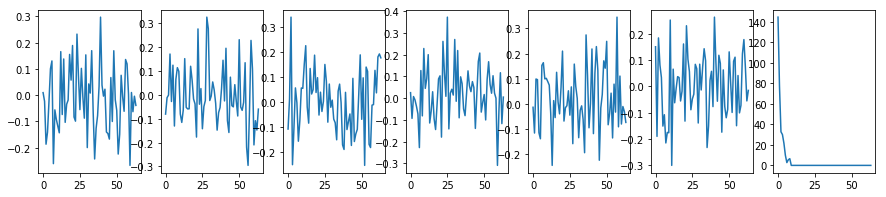

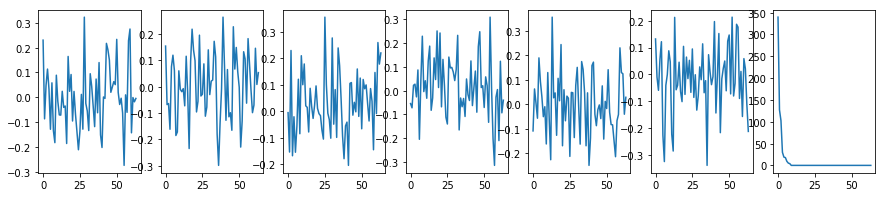

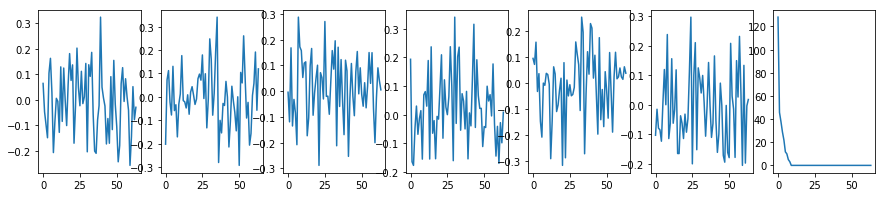

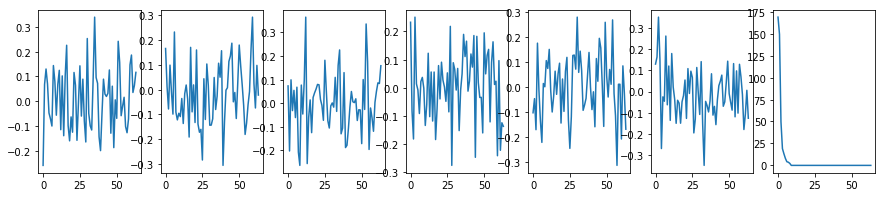

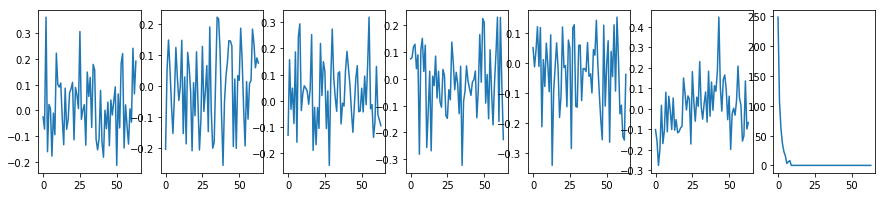

In [13]:
plt.show()
# the averaged enbedding for each word are similar to each other.they should be more different than this.
# what goes wrong?